In [1]:
import sys
from os.path import dirname
sys.path.append(dirname("/home/nannau/msc/DoWnGAN/"))


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

from dataloader import NetCDFSR, xr_standardize_field, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch
import datetime
import pandas as pd
from prep_gan import find_nearest_index, to_utc

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator

import seaborn as sns


import matplotlib.pyplot as plt

plt.style.use(['science','no-latex'])
plt.rcParams.update({"figure.figsize":  (5,10),
                    'font.family': 'Times New Roman',
                    'font.size': 25,
                    'lines.linewidth': 2.5})


from models.generator import Generator
from models.critic import Critic
# import geopandas as gpd

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

In [2]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=4, threads_per_worker=1, memory_limit="4GB")
client

Client Scheduler: tcp://127.0.0.1:38875 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 14.90 GiB


In [3]:
hr_dataroot_U10 = "../data/wrf/U10/regrid_10_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "../data/wrf/V10/regrid_10_6hrly_wrf2d_d01_ctrl_V10*.nc"

hr_dataroot_U10 = "../data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "../data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc"

fine_u = xr.open_mfdataset(glob.glob(hr_dataroot_U10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})
fine_v = xr.open_mfdataset(glob.glob(hr_dataroot_V10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})

dataroot = "../data/interim_2000-10-01_to_2013-09-30.nc"

target = '10UV_GDS4_SFC'
coarse = xr.open_dataset(dataroot).astype("float")
coarse = coarse.sortby('latitude', ascending=True)
coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

# scale factor
sf = 8

In [4]:
Times_dt = []
for t in fine_u.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(np.datetime64(datetime.datetime(year, month, day, hours)))
Times_dt = np.array(Times_dt).astype('datetime64[D]')
Times_dt_pd = pd.DatetimeIndex(Times_dt)
filter_func = np.vectorize(lambda x: True if x.month in [6, 7, 8, 9, 10] else False)
time_mask = filter_func(Times_dt_pd.astype(object))

i_list = np.arange(len(time_mask))
i_list[time_mask]

time_mask = np.ones(Times_dt.shape[0]) != 1
time_mask[1:18000:] = True

In [5]:
low, up, l, r = 4, 20, 70, 86

In [6]:
u10 = fine_u.U10[time_mask, sf*low:sf*up, sf*l:sf*r]
v10 = fine_v.V10[time_mask, sf*low:sf*up, sf*l:sf*r]

coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

coarse_u10_patch = coarse_u10[time_mask, low:up, l:r]
coarse_v10_patch = coarse_v10[time_mask, low:up, l:r]

u10 = xr_standardize_field(u10)
v10 = xr_standardize_field(v10)
coarse_u10 =  xr_standardize_field(coarse_u10_patch)
coarse_v10 =  xr_standardize_field(coarse_v10_patch)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


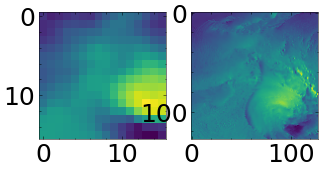

In [7]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [8]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

In [9]:
fine_t = torch.from_numpy(fine)#.double()
coarse_t = torch.from_numpy(coarse)#.double()

In [10]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        times,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine[times, ...]#.to(device)
        self.coarse = coarse[times, ...]#.to(device)

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]

#         arr = torch.unsqueeze(arr, 0)
#         carr = torch.unsqueeze(carr, 0)

#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr

dataset = NetCDFSR(
    fine_t,
    coarse_t,
    i_list[time_mask][:1000],
    device=device,
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1000,
    shuffle=True
)

real_batch, real_cbatch = next(iter(dataloader))
fixed = {"coarse": real_cbatch, "fine": real_batch}
fixed["coarse"].size()

torch.Size([1000, 2, 16, 16])

In [11]:
import mlflow
hashed = "5347f0446e364ece98f3d652436f8462"
logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hashed}/artifacts/Generator'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
G = mlflow.pytorch.load_model(logged_model).to(device)

# state_dict_uri = mlflow.get_artifact_uri(artifact_path)
state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
G.load_state_dict(state_dict)
# loaded_model(fixed["coarse"].to(device))

<All keys matched successfully>

In [12]:
batch_size=64
i = np.random.randint(0, batch_size)

In [13]:
real = fixed["fine"][i, 1, ...].detach().numpy()
coarse = fixed["coarse"][i, 1, ...].detach().numpy()

Text(0.5, 1.0, 'Ground Truth')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


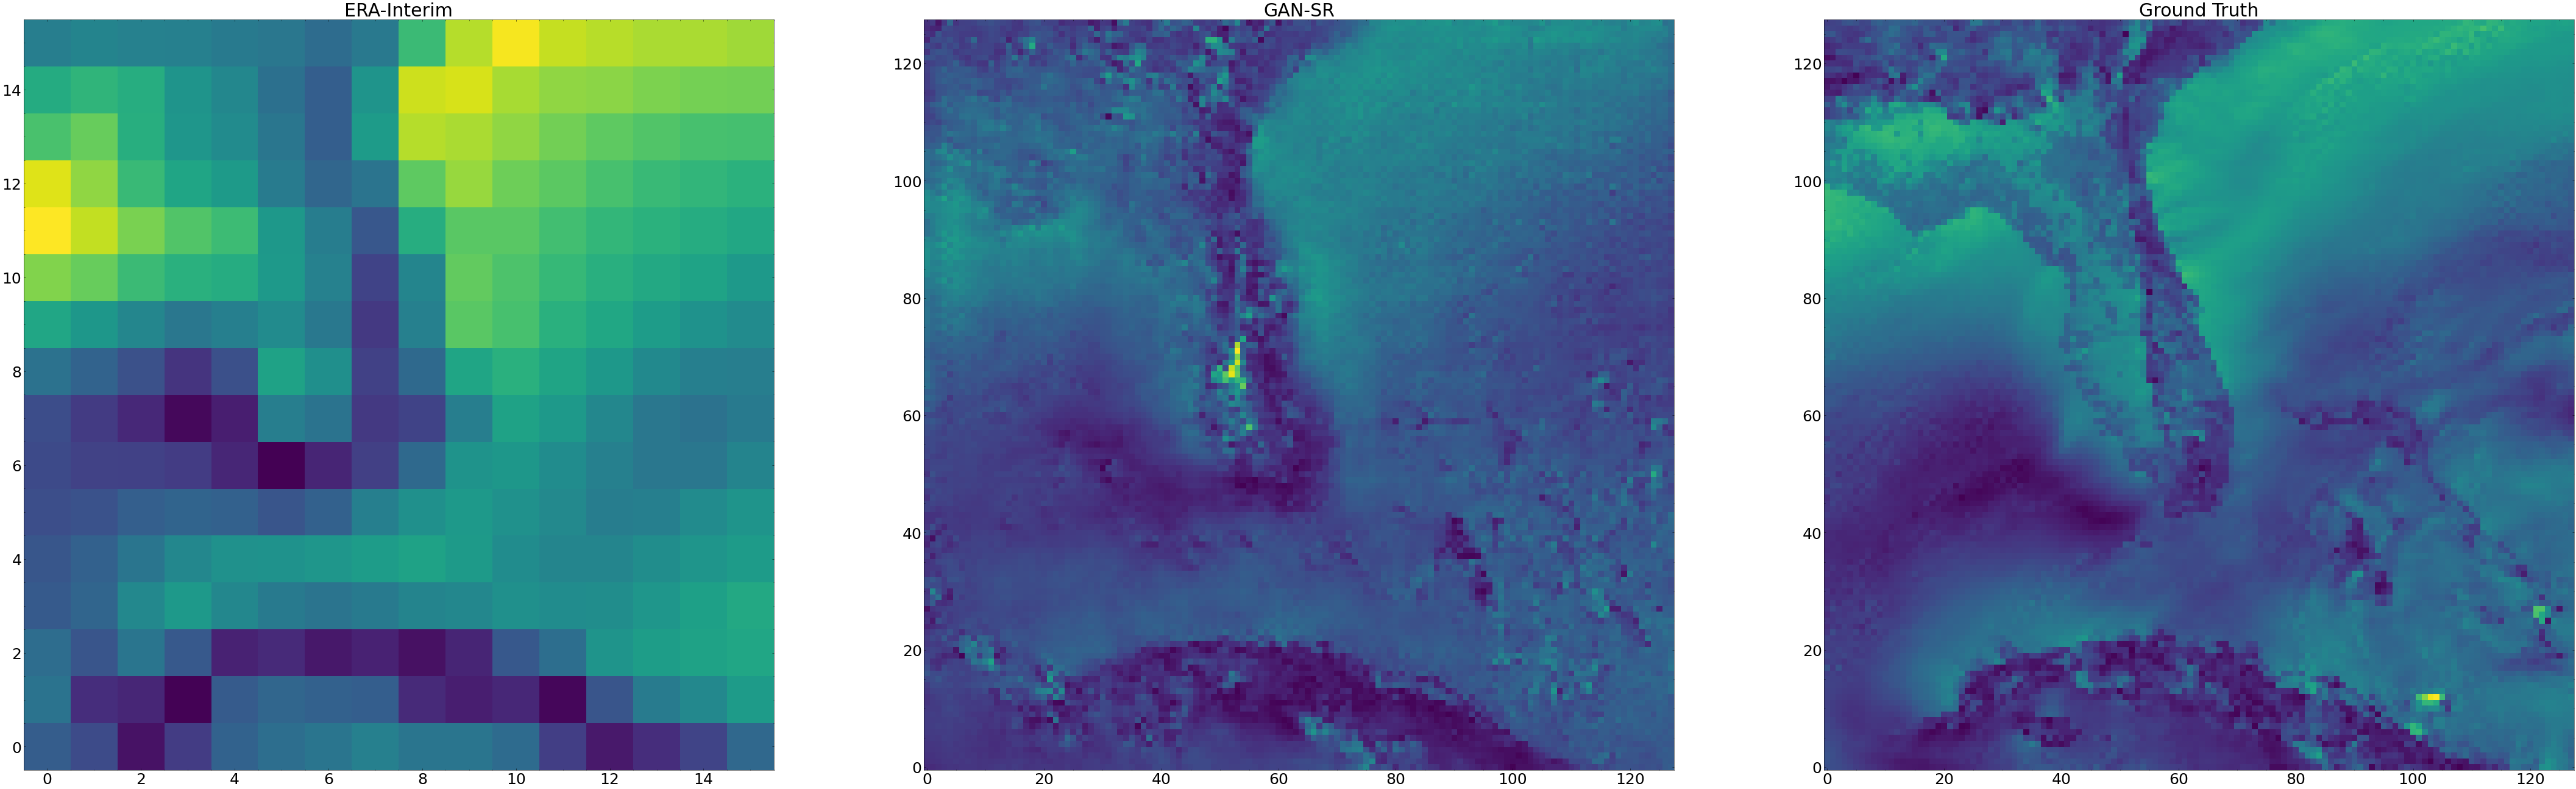

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(75, 75))
# np.random.seed(500)
i = np.random.randint(0, batch_size)

N1 = 3
N2 = N1+3
    
# i = np.random.randint(0, batch_size)

# real = fixed["fine"][i, 1, ...].detach().numpy()
# coarse = fixed["coarse"][i, 1, ...].detach().numpy()

coarse_hypot = np.hypot(
    fixed["coarse"][i, 0, ...].detach().numpy(),
    fixed["coarse"][i, 1, ...].detach().numpy()
)

u10_fake = G(fixed["coarse"].float().to(device))[i, 0, ...].detach().cpu().numpy()
v10_fake = G(fixed["coarse"].float().to(device))[i, 1, ...].detach().cpu().numpy()

real = fixed["fine"][i, 1, ...].detach().numpy()

u10_real = fixed["fine"][i, 0, ...].detach().numpy()
v10_real = fixed["fine"][i, 1, ...].detach().numpy()

speed_fake = np.hypot(u10_fake, v10_fake)
speed_real = np.hypot(u10_real, v10_real)

#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)

# Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)

ax[0].imshow(coarse_hypot, origin="lower")
ax[0].set_title("ERA-Interim")
ax[1].imshow(speed_fake, origin="lower")
ax[1].set_title("GAN-SR")
ax[2].imshow(speed_real, origin="lower")
ax[2].set_title("Ground Truth")

In [15]:
from scipy.interpolate import interp2d
x = np.arange(coarse.shape[0])
y = np.arange(coarse.shape[1])
nx = np.linspace(x.min(), x.max(), sf*x.shape[0])
ny = np.linspace(y.min(), y.max(), sf*y.shape[0])

In [16]:
from sklearn.decomposition import PCA
pca = PCA(250)
pcav = PCA(250)

In [17]:
pca_shape = (np.sum(time_mask), fine.shape[2]*fine.shape[3])
X = fine[:, 0, ...].reshape(pca_shape)
Xv = fine[:, 1, ...].reshape(pca_shape)

In [18]:
pca.fit(X)
pcav.fit(Xv)

PCA(n_components=250)

In [19]:
pca_og_shape = torch.from_numpy(np.stack([pca.components_, pcav.components_], axis=1))

In [20]:
torch.matmul(pca_og_shape[:, 0, ...].T, torch.from_numpy(Z[0, ...]))

NameError: name 'Z' is not defined

In [ ]:
# pca.components_

In [21]:
Z = pca.transform(X)

In [22]:
Z.shape

(17999, 250)

In [23]:
fine_t.size()
torch.from_numpy(pca.components_.T).size()

torch.Size([16384, 250])

In [24]:
# torch.from_numpy(pca.components_.T)
# fine_t
Aa = torch.from_numpy(pca.components_.T)
Zz = torch.from_numpy(Z)

# x = np.matmul(pca.components_.T, Z[jj, ...]).reshape(fine.shape[2], fine.shape[3])
all_low = np.array([np.matmul(pca.components_.T, Z[i, ...]).reshape(fine.shape[2], fine.shape[3]) for i in range(Zz.size(0))])
    

In [26]:
# pca.components_.T.size()

In [ ]:
torch.matmul(torch.from_numpy(pca.components_[:, 0, ...]), torch.from_numpy(Z[i, 0, ...]))

In [25]:
batch_low_u = torch.from_numpy(np.array([torch.reshape(torch.matmul(pcas[:, 0, ...], Z[i, 0, ...]), (fine.size(2), fine.size(3))) for i in range(Z.size(0))]))


TypeError: 'int' object is not callable

In [27]:
all_low.shape

(17999, 128, 128)

In [28]:
jj = 5201

In [29]:
# x = np.matmul(pca.components_.T, Z[jj, ...]).reshape(fine.shape[2], fine.shape[3])
# x = np.sum(x, axis=1).reshape(fine.shape[2], fine.shape[3])
x = all_low[jj, ...]

Text(0.5, 1.0, 'Ground Truth')

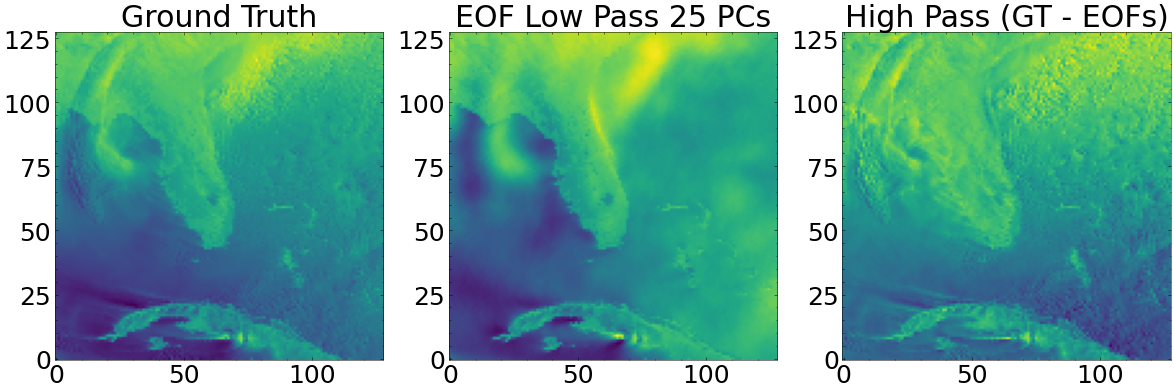

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[2].imshow(fine[jj, 0, ...]-x, origin="lower")
ax[2].set_title("High Pass (GT - EOFs)")
ax[1].imshow(x, origin="lower")
ax[1].set_title("EOF Low Pass 25 PCs")
ax[0].imshow(fine[jj, 0, ...], origin="lower")
ax[0].set_title("Ground Truth")

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
mean_squared_error(fine[jj, 0, ...], x)

0.14682901

In [ ]:
x.max(), fine[jj, 0, ...].max()